<a href="https://colab.research.google.com/github/AmeerHamza0220/Deep-Learning/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf

In [18]:
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (112, 112))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (112, 112))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // 16
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

#batches 
train_batches = train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_images.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
from keras.applications.vgg16 import VGG16
#import conv2d and conv2d_transpose
from keras.layers import Conv2D, Conv2DTranspose,Dropout
#create fcn model for segmentation
def create_fcn_model(input_shape, num_classes):
    #import vgg16 from keras application
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    #replace last 3 fcn layers with conv2d
    f3 = vgg16.get_layer('block3_pool').output  #shape=(14,14, 512)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (7,7 512)
    #pop last 3 layers
    vgg16.layers.pop()

    #replace by convulution
    

    xf4= Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='relu')(f4)
   

    #upsample x4 uisng transpose convolution
    x4 = Conv2DTranspose(filters=num_classes, kernel_size=4, strides=2, padding='same', activation='relu')(xf4)
    xf3= Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='relu')(f3)
    #merge x4 and f3
    merge= tf.add(x4,xf3)
    print(merge.shape)
    #upscale merge2 from 28x28 to 112x112
    output = Conv2DTranspose(filters=num_classes, kernel_size=16, strides=8, padding='same', activation=None)(merge)

    #create model
    model = tf.keras.models.Model(inputs=vgg16.input, outputs=output)

    return model

fcn=create_fcn_model(input_shape=(112,112,3), num_classes=3)
fcn.summary()
    

    



(None, 14, 14, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 112, 112, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 112, 112, 64  36928       ['block1_conv1[0][0]']           
                                )                                         

 semantic segmentation is nothing but classification at the pixel-level (instead of image-level). Therefore, the same loss function can be used: cross-entropy.

In [31]:
fcn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

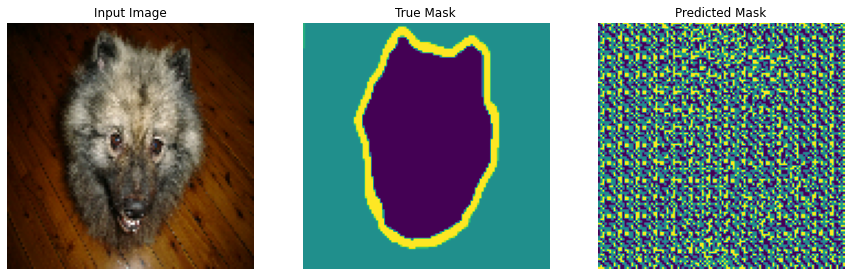

In [32]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = fcn.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions(train_batches, 1)


In [26]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(train_batches, num=1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

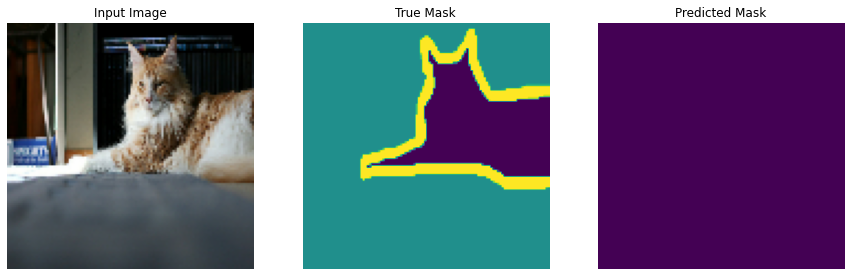


Sample Prediction after epoch 4



KeyboardInterrupt: 

In [27]:
EPOCHS = 16
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = fcn.fit(train_batches, epochs=EPOCHS,                  validation_data=test_batches,
                          callbacks=[DisplayCallback()],verbose=0)